### Imports
---

In [2]:
import ast
import numpy as np
import json
import torch
import equitrain
import matplotlib
import matplotlib.pyplot as plt
import scipy
import torch_geometric

from tqdm import tqdm
from equitrain.equiformer_v1 import DotProductAttentionTransformerOC20

from equitrain.mace.data  import HDF5Dataset

/home/pbenner/.local/opt/anaconda3/envs/equiformer_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
### Definitions
---

In [1]:
device = 'cuda:3'
model_path = 'result-11/best_val_epochs@5_e@665.9855/pytorch_model.bin'

---
### Load data
---

In [3]:
r_max=5.0

In [4]:
torch.set_default_dtype(torch.float32)

In [5]:
with open(f'data-r{r_max}/statistics.json', "r") as f:
    statistics = json.load(f)

zs_list = ast.literal_eval(statistics["atomic_numbers"])
z_table = equitrain.mace.tools.get_atomic_number_table_from_zs(zs_list)

In [6]:
model = DotProductAttentionTransformerOC20(
    # First three arguments are not used
    None, None, None,
    max_radius=r_max,
    max_num_elements=95)
model = model.to(device)

In [7]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [8]:
valid_set = HDF5Dataset(
    f'data-r{r_max}/valid.h5', r_max=r_max, z_table = z_table,
)

In [9]:
valid_loader = torch_geometric.loader.DataLoader(
    dataset=valid_set,
    batch_size=1,   
    shuffle=False,
    drop_last=False,
    pin_memory=False,
    num_workers=1,
)

---
### Collect groundtruth and predictions
---

In [10]:
energy_true = []
energy_pred = []

forces_true = [[], [], []]
forces_pred = [[], [], []]

stress_true = [[], [], [], [], [], [], [], [], []]
stress_pred = [[], [], [], [], [], [], [], [], []]

n = 1000
#n = len(valid_loader)

for i, batch in tqdm(enumerate(valid_loader), total=n):
    if i >= n:
        break

    batch = batch.to(device)
    energy, forces, stress = model(batch)

    energy_true.extend([ e.item() for e in batch.y ])
    energy_pred.extend([ e.item() for e in energy ])

    for i in range(3):

        forces_true[i].extend([ f[i].item() for f in batch['force'] ])
        forces_pred[i].extend([ f[i].item() for f in forces ])

    for i in range(3):

        for j in range(3):

            k = i*3 + j

            stress_true[k].extend([ s[i][j].item() for s in batch ['stress'] ])
            stress_pred[k].extend([ s[i][j].item() for s in stress ])


100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


In [11]:
def mae(true, pred):
    return np.mean(np.abs(np.array(true) - np.array(pred)))

---
### Energy parity plot
---

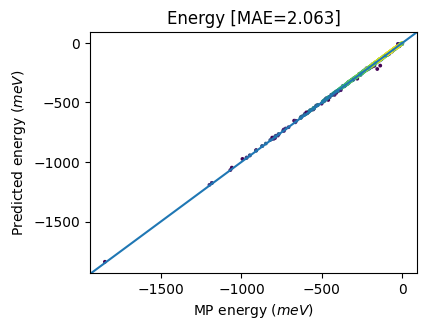

In [12]:
title = f'Energy [MAE={mae(energy_true, energy_pred):.3f}]'

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
fig.tight_layout()

xy = np.vstack([energy_true, energy_pred])
z = scipy.stats.gaussian_kde(xy)(xy)

ax.scatter(energy_true, energy_pred, c=z, s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
ax.axline((0,0), slope=1)
ax.set_title(title)
ax.set_xlabel(r'MP energy ($meV$)')
ax.set_ylabel(r'Predicted energy ($meV$)')

plt.show()

---
### Forces parity plot
---

/tmp/ipykernel_3455741/354986104.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(forces_true[i], forces_pred[i], s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())


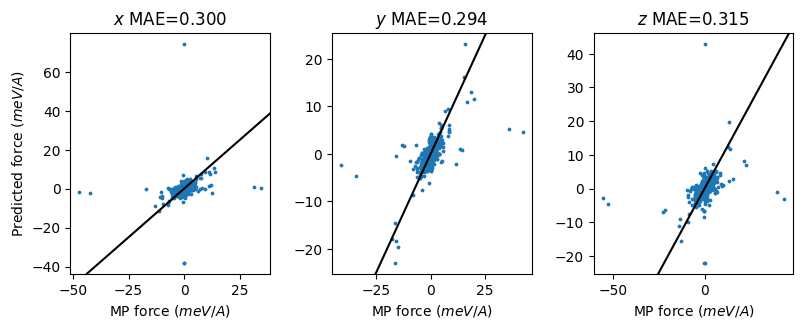

In [13]:
titles = [r'$x$', r'$y$', r'$z$']

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
fig.tight_layout()

for i, ax in enumerate(axs.flatten()):

    #xy = np.vstack([forces_true[i], forces_pred[i]])
    #z = scipy.stats.gaussian_kde(xy)(xy)

    #ax.scatter(forces_true[i], forces_pred[i], c=z, s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.scatter(forces_true[i], forces_pred[i], s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.axline((0,0), slope=1, color='black')
    ax.set_title(f'{titles[i]} MAE={mae(forces_true[i], forces_pred[i]):.3f}')
    ax.set_xlabel(r'MP force ($meV/A$)')
    if i == 0:
        ax.set_ylabel(r'Predicted force ($meV/A$)')

plt.show()

---
### Stress parity plot
---

/tmp/ipykernel_3455741/3867538040.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(np.array(stress_true[i]), stress_pred[i], s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())


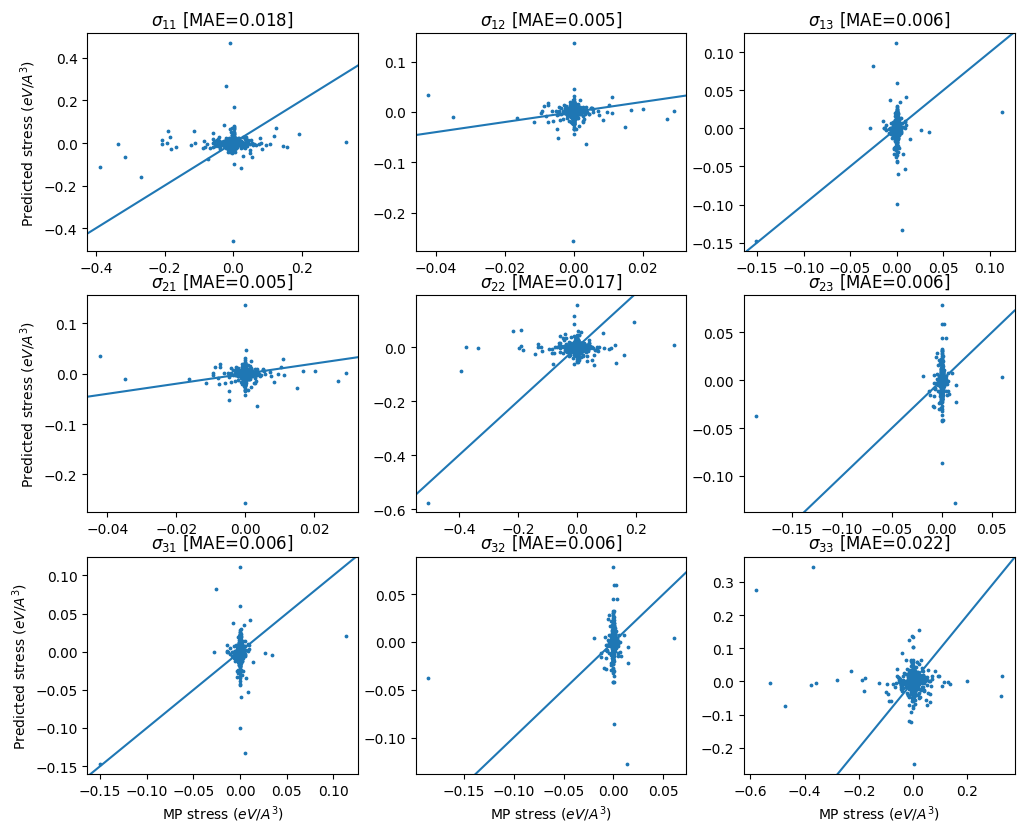

In [15]:
titles = [r'$\sigma_{11}$', r'$\sigma_{12}$', r'$\sigma_{13}$',
          r'$\sigma_{21}$', r'$\sigma_{22}$', r'$\sigma_{23}$',
          r'$\sigma_{31}$', r'$\sigma_{32}$', r'$\sigma_{33}$']

fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.tight_layout()

for i, ax in enumerate(axs.flatten()):

    #xy = np.vstack([stress_true[i], stress_pred[i]])
    #z = scipy.stats.gaussian_kde(xy)(xy)

    #ax.scatter(stress_true[i], stress_pred[i], c=z, s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.scatter(np.array(stress_true[i]), stress_pred[i], s=3, edgecolor=None, norm=matplotlib.colors.LogNorm())
    ax.axline((0,0), slope=1)
    ax.set_title(f'{titles[i]} [MAE={mae(stress_true[i], stress_pred[i]):.3f}]')
    if i in [6, 7, 8]:
        ax.set_xlabel(r'MP stress ($eV/A^3$)')
    if i in [0, 3, 6]:
        ax.set_ylabel(r'Predicted stress ($eV/A^3$)')

plt.show()